### Loading libraries and data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.cluster.vq import vq
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import os
import gzip 


np.random.seed(42)


In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
X_train, y_train = load_mnist('./data', kind='train')
X_test, y_test = load_mnist('./data', kind='t10k')

class_names= ["T-shirt/top", "Trouser", "Pullover", "Dress",
              "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

### Let us look at the data

In [5]:
print(X_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0
   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0
  36 136 127  62  54   0   0   0   1   3   4   0   0   3   0   0   0   0
   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0
   0   0   0  12  10   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15   0   0
   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163
 127 121 122 146 141  88 172  66   0   0   0   0   0   0   0   0   0   1
   1   1   0 200 232 232 233 229 223 223 215 213 16

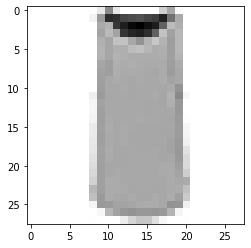

T-shirt/top
- - - - - - - - - - - -


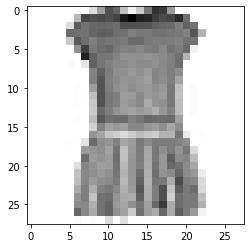

Dress
- - - - - - - - - - - -


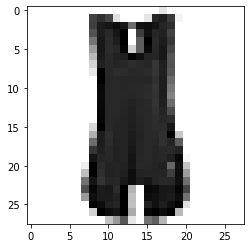

T-shirt/top
- - - - - - - - - - - -


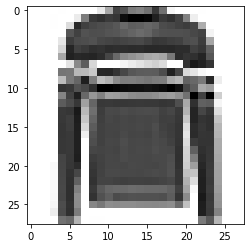

Pullover
- - - - - - - - - - - -


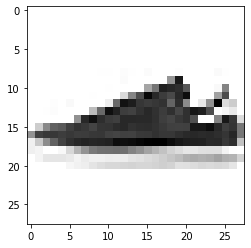

Sneaker
- - - - - - - - - - - -


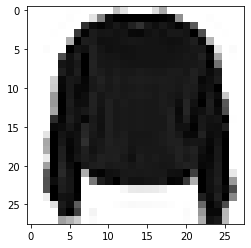

Pullover
- - - - - - - - - - - -


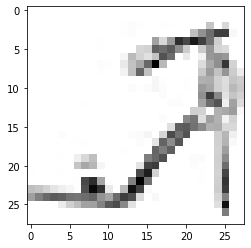

Sandal
- - - - - - - - - - - -


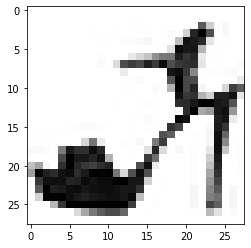

Sandal
- - - - - - - - - - - -


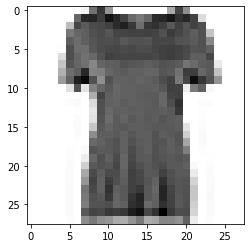

T-shirt/top
- - - - - - - - - - - -


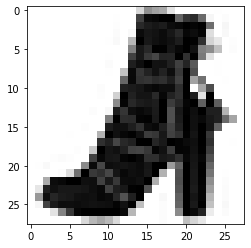

Ankle boot
- - - - - - - - - - - -


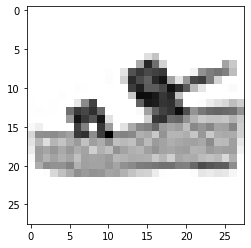

Sandal
- - - - - - - - - - - -


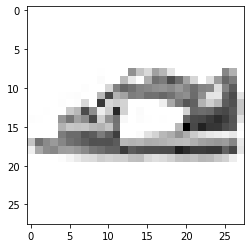

Sandal
- - - - - - - - - - - -


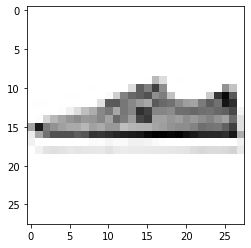

Sneaker
- - - - - - - - - - - -


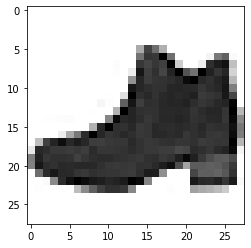

Ankle boot
- - - - - - - - - - - -


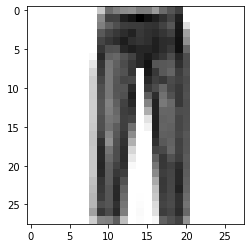

Trouser
- - - - - - - - - - - -


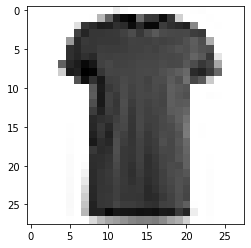

T-shirt/top
- - - - - - - - - - - -


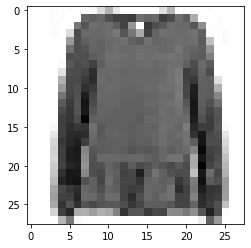

Shirt
- - - - - - - - - - - -


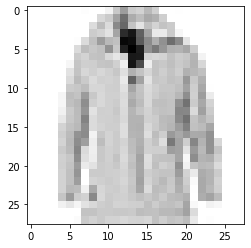

Coat
- - - - - - - - - - - -


In [6]:

for i in range(2,20):
    plt.imshow(X_train[i].reshape(28,28), cmap="binary")
    plt.show()

    print(class_names[y_train[i]])
    print("- - - - - - - - - - - -")

In [7]:
np.max(X_train), np.min(X_train)

(255, 0)

#### we shall scale the ranges to [0,1]

In [8]:
# so the values are betwenn 0 to 255
# we now scale the values to lie between 0 and 1
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

### Running the Experiment

#### Logistic Regression on full dataset

In [10]:
## so here we just do the regression and see what we get will the full data
log_reg=LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_train,y_train)

tescor = log_reg.score(X_test, y_test)
print(tescor)

0.841


In [12]:
results = pd.DataFrame(columns = ["Type","Test score","Label Accuracy"])

#### Transferring the results to our data frame

In [13]:
results = results.append( {"Type":"Full","Test score":tescor,
                           "Label Accuracy": 1}, ignore_index=True )

In [14]:
###
clusts = 58
perc = 10

#### Now we cluster and find the closest representatives

In [15]:
## now we cluster and see what we get
kmeans = KMeans(n_clusters = clusts, random_state=42)
X_items_dist = kmeans.fit_transform(X_train)
print("clustered into %s clusters" %clusts )
representative_ids = np.argmin(X_items_dist, axis=0)
representatives = X_train[representative_ids]

clustered into 58 clusters


In [17]:
itemnames = y_train[representative_ids]

#### We look at the distribution of the y labels of our representatives

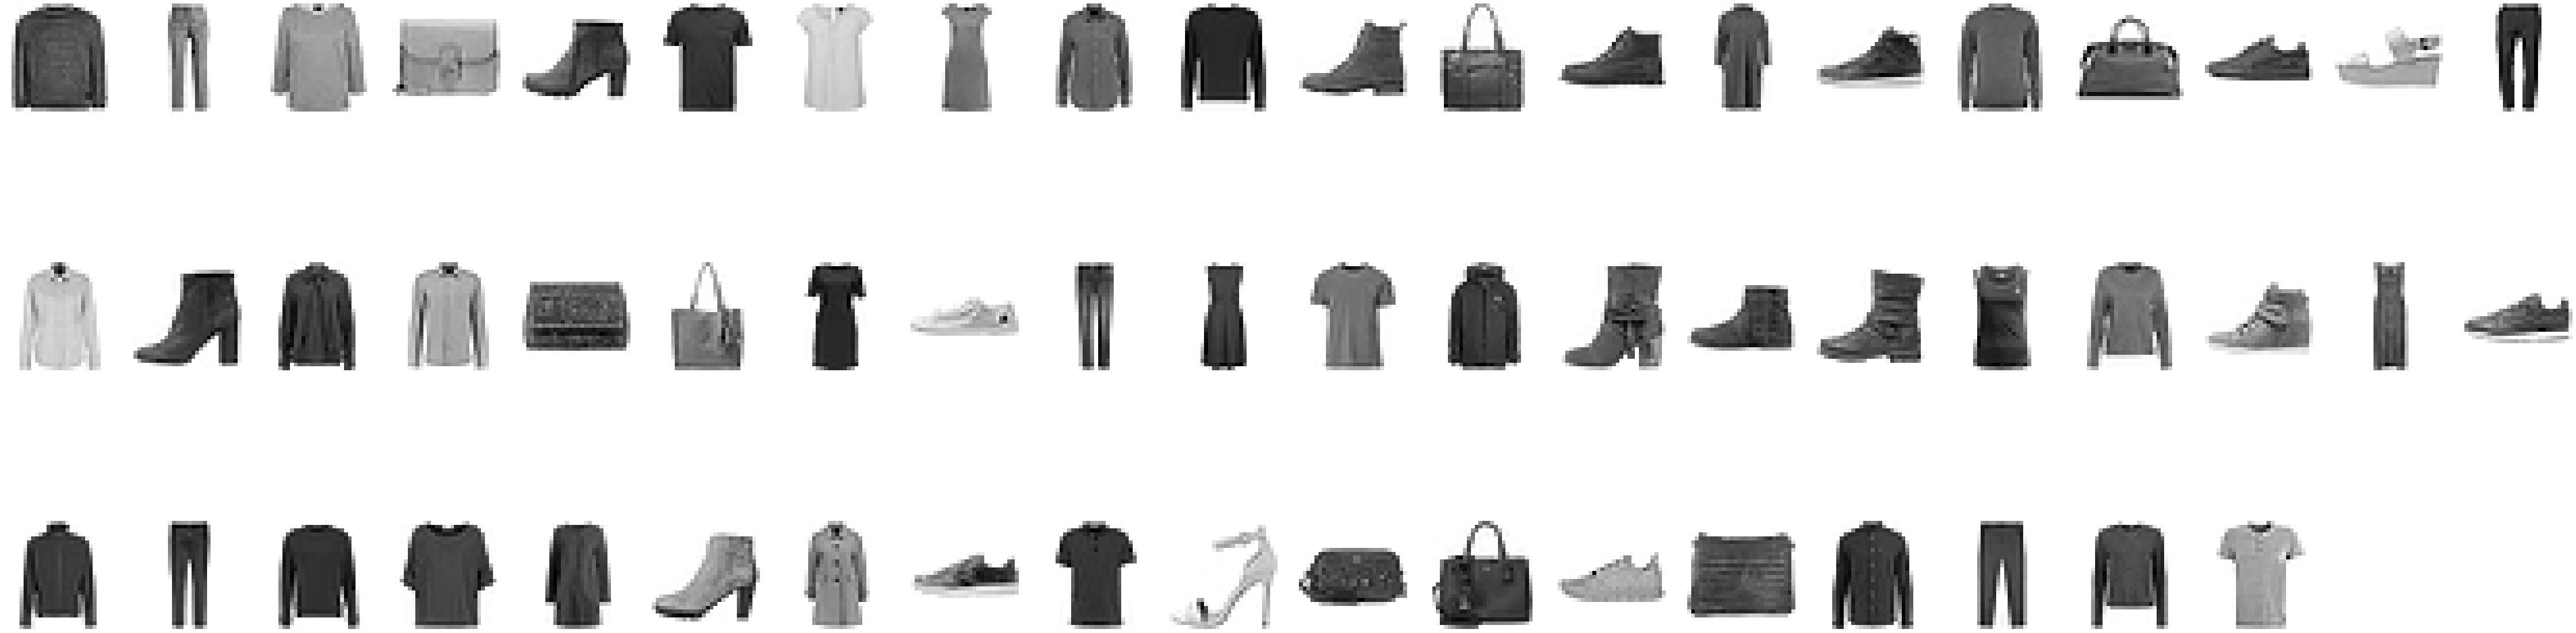

In [18]:
## let us just take a look at these representatives
plt.figure(figsize=(80,40))
for i, item in enumerate(representatives):
    plt.subplot(clusts//10, 20, i+1)
    plt.imshow(item.reshape(28,28), cmap="binary")
    plt.axis('off')
plt.show()

#### We now apply logistic regression on only the cluster representatives

In [19]:
# now we cluster on this 50 items which were chosen as clustered
log_reg=LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(representatives,itemnames)


tescor = log_reg.score(X_test, y_test)
print(tescor)

0.6644


#### Appending the results to our dataframe

In [20]:
results = results.append( {"Type":"Cluster Pts","Test score":tescor,
                           "Label Accuracy": 1}, ignore_index=True )

#### Propagating the label to all the points

In [21]:
# now we propagate our labels to all of the others
y_train_propagate = np.empty(len(X_train), dtype=np.int32)
for i in range(clusts):
    y_train_propagate[kmeans.labels_ == i] = itemnames[i]

In [22]:
# let us look at the accuracy of the labels
acc = np.mean(y_train_propagate == y_train)
print(acc)

0.6627166666666666


In [23]:
log_reg=LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_train, y_train_propagate)


tescor = log_reg.score(X_test, y_test)
print(tescor)

0.6632


#### Appending the results to our dataframe

In [24]:
results = results.append( {"Type":"Full Propagation","Test score":tescor,
                           "Label Accuracy": acc}, ignore_index=True )

#### Propagating to only about {prec}% of the points

In [25]:
# now we propagate to the closest {perc} percent

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(clusts):
    picked_cluster_ids = (kmeans.labels_==i)
    cluster_l2s = X_cluster_dist[picked_cluster_ids]
    selected_criterion = np.percentile(cluster_l2s, perc)
    failed_ids = (X_cluster_dist > selected_criterion)
    X_cluster_dist[picked_cluster_ids & failed_ids] = -1

selected_ids = (X_cluster_dist != -1)    
X_train_partial = X_train[selected_ids]
y_train_partial = y_train_propagate[selected_ids]

In [26]:
# now we look at the accuracy
acc = np.mean( y_train_propagate[selected_ids] == y_train[selected_ids] )
print(acc)

0.7935954869752779


In [27]:
log_reg=LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_train_partial, y_train_partial)


tescor = log_reg.score(X_test, y_test)
print(tescor)

0.6658


In [28]:
results = results.append( {"Type":str(perc) + "% Propagate", "Test score":tescor,
                           "Label Accuracy": acc}, ignore_index=True )

In [29]:
perc += perc

#### Propagating to only about {prec}% of the points

In [30]:
# now we propagate to the closest {perc} percent

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(clusts):
    picked_cluster_ids = (kmeans.labels_==i)
    cluster_l2s = X_cluster_dist[picked_cluster_ids]
    selected_criterion = np.percentile(cluster_l2s, perc)
    failed_ids = (X_cluster_dist > selected_criterion)
    X_cluster_dist[picked_cluster_ids & failed_ids] = -1

selected_ids = (X_cluster_dist != -1)    
X_train_partial = X_train[selected_ids]
y_train_partial = y_train_propagate[selected_ids]

In [31]:
# now we look at the accuracy
acc = np.mean( y_train_propagate[selected_ids] == y_train[selected_ids] )
print(acc)

0.771540252827678


In [32]:
log_reg=LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_train_partial, y_train_partial)


tescor = log_reg.score(X_test, y_test)
print(tescor)

0.665


In [33]:
results = results.append( {"Type":str(perc) + "% Propagate", "Test score":tescor,
                           "Label Accuracy": acc}, ignore_index=True )

In [34]:
perc = int( (3/2)*perc )

#### Propagating to only about {prec}% of the points

In [35]:
# now we propagate to the closest {perc} percent

X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(clusts):
    picked_cluster_ids = (kmeans.labels_==i)
    cluster_l2s = X_cluster_dist[picked_cluster_ids]
    selected_criterion = np.percentile(cluster_l2s, perc)
    failed_ids = (X_cluster_dist > selected_criterion)
    X_cluster_dist[picked_cluster_ids & failed_ids] = -1

selected_ids = (X_cluster_dist != -1)    
X_train_partial = X_train[selected_ids]
y_train_partial = y_train_propagate[selected_ids]

In [36]:
# now we look at the accuracy
acc = np.mean( y_train_propagate[selected_ids] == y_train[selected_ids] )
print(acc)

0.7552175843694494


In [37]:
log_reg=LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000)
log_reg.fit(X_train_partial, y_train_partial)


tescor = log_reg.score(X_test, y_test)
print(tescor)

0.668


In [38]:
results = results.append( {"Type":str(perc) + "% Propagate", "Test score":tescor,
                           "Label Accuracy": acc}, ignore_index=True )

In [39]:
print("Clustered into %s Clusters" % clusts)
results

Clustered into 58 Clusters


,Type,Test score,Label Accuracy
0,Full,0.8410,1
1,Cluster Pts,0.6644,1
2,Full,0.6632,0.662717
3,10% Propagate,0.6658,0.793595
4,20% Propagate,0.6650,0.77154
5,30% Propagate,0.6680,0.755218


In our opinion, the full propagation of the label does not provide a good accuracy mainly because of how low the label accuracy is. If it is accurate around 65% of the time, then the model is learning wrong things other times and so we end up with a lower score (as compared to the actual FULL type labelled dataset). We get better scores, as compared to the Full propagation, at 30%, 20% and 10% propagation but it is on the scale of 0.1% of better accuracy and these may also be attributed to statistical variations

Observe that in the MNIST digits dataset in the lecture we were jumping on the accuracy by atleast 1%. We think this is manily because in the fashion dataset there are more pictures which can be mistaken for each other than in the digits.

Mistaken: (for each other in brackets) 
- Mistaken in digits: {7,4,1,2}, {8,3}  
- Mistaken in fashion: {Tshirt/top,pullover,shirt} {coat,dress} {sandal, sneaker, ankleboot}